In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats

In [2]:
# Load the data
data = pd.read_csv("study_data.csv", low_memory=False)

# Feature transformation function
def transform_features(data):
    cols = data.columns.values
    for col in cols[:-2]:  # Excluding the target columns
        if col.startswith('Details.Description') or col.startswith('Website.') or col.startswith('Overview') or col.startswith('Education') or col.startswith('Major'):
            if col not in ["Overview.Gender.Agender", "Overview.Gender.Non-Binary"]:
                # Z-score normalization grouped by 'Years Since Founded'
                data[col] = data.groupby('Details.Years Since Founded')[col].transform(lambda x: stats.zscore(x, ddof=1, nan_policy='omit'))
                # Additional transformations
                if np.any(data[col] <= 0):
                    data[col] += 1  # Ensure positive values for logarithmic transformation
                data[col] = np.sqrt(np.log(data[col]))

    return data

In [3]:
# Apply feature transformations
data = transform_features(data)

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Normalize the features
scaler = StandardScaler()
features = data_imputed.drop(columns=['Target', 'Details.Years Since Founded'])
data_imputed[features.columns] = scaler.fit_transform(features)

# Normalize the regression target
target_scaler = StandardScaler()
data_imputed['Details.Years Since Founded'] = target_scaler.fit_transform(data_imputed[['Details.Years Since Founded']])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_imputed[features.columns], data_imputed[['Target', 'Details.Years Since Founded']], test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountere

In [4]:
# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.classifier = nn.Linear(32, 1)
        self.regressor = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        classification_output = torch.sigmoid(self.classifier(x))
        regression_output = self.regressor(x)
        return classification_output, regression_output



In [5]:
# Create the model, specify loss functions and optimizer
model = SimpleNN(input_size=X_train.shape[1])
classification_loss_function = nn.BCELoss()
regression_loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Prepare data loaders
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(y_train.values, dtype=torch.float))
val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float), torch.tensor(y_val.values, dtype=torch.float))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for features, targets in train_loader:
        optimizer.zero_grad()
        classification_preds, regression_preds = model(features)
        classification_loss = classification_loss_function(classification_preds, targets[:, 0].unsqueeze(1))
        regression_loss = regression_loss_function(regression_preds, targets[:, 1].unsqueeze(1))
        loss = classification_loss + regression_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for features, targets in val_loader:
            classification_preds, regression_preds = model(features)
            classification_loss = classification_loss_function(classification_preds, targets[:, 0].unsqueeze(1))
            regression_loss = regression_loss_function(regression_preds, targets[:, 1].unsqueeze(1))
            loss = classification_loss + regression_loss
            val_loss += loss.item()
        print(f'Validation Loss: {val_loss / len(val_loader)}')


Epoch 1, Loss: 1.6779235948490192
Validation Loss: 1.443794485926628
Epoch 2, Loss: 1.5265060451966297
Validation Loss: 1.40568950176239
Epoch 3, Loss: 1.4606913426254369
Validation Loss: 1.396964541077614
Epoch 4, Loss: 1.4012421905239927
Validation Loss: 1.3909475803375244
Epoch 5, Loss: 1.3557454513598093
Validation Loss: 1.3754665940999984
Epoch 6, Loss: 1.316294703302504
Validation Loss: 1.436188417673111
Epoch 7, Loss: 1.2879299234740342
Validation Loss: 1.4385398000478744
Epoch 8, Loss: 1.2492241595364824
Validation Loss: 1.4129710435867309
Epoch 9, Loss: 1.2077833708328536
Validation Loss: 1.447504910826683
Epoch 10, Loss: 1.1787224223342123
Validation Loss: 1.4549585431814194


In [7]:
# Evaluation
all_class_preds = []
all_regress_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for features, targets in val_loader:
        class_preds, regress_preds = model(features)
        all_class_preds.append(class_preds.flatten())
        all_regress_preds.append(regress_preds.flatten())
        all_targets.append(targets)

all_class_preds = torch.cat(all_class_preds)
all_regress_preds = torch.cat(all_regress_preds)
all_targets = torch.cat(all_targets)

In [8]:
# Inverse transform regression predictions for accurate MSE
actual_years = target_scaler.inverse_transform(all_targets[:, 1].numpy().reshape(-1, 1))
predicted_years = target_scaler.inverse_transform(all_regress_preds.numpy().reshape(-1, 1))
accuracy = accuracy_score(all_targets[:, 0].numpy(), all_class_preds.numpy().round())
mse = mean_squared_error(actual_years, predicted_years)

print(f"Accuracy: {accuracy:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

Accuracy: 0.6440
Mean Squared Error: 195.7349


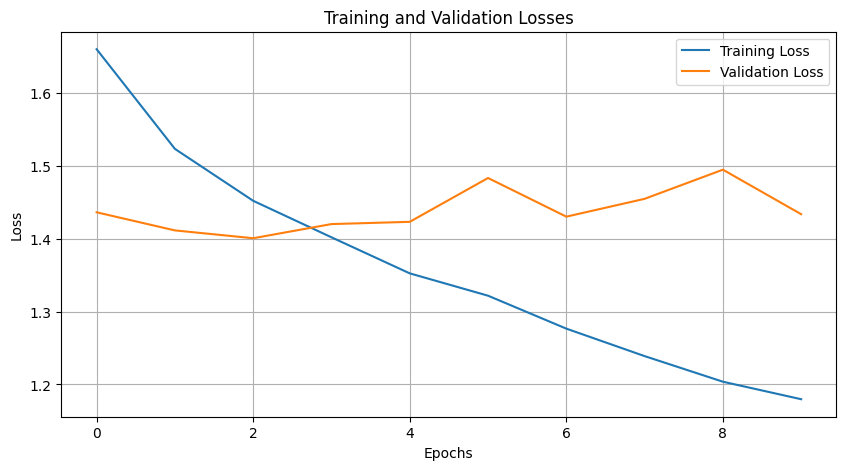

In [9]:
import matplotlib.pyplot as plt

# Assuming 'train_losses' and 'val_losses' are lists containing loss values per epoch
train_losses = [1.6598781769788717, 1.523151674602605, 1.4519075011905236, 1.4018173195138763, 1.3523464964914926,
                1.321697646304022, 1.2765077616595015, 1.2388252465030816, 1.2036968326266808, 1.1796704062932655]
val_losses = [1.4361283779144287, 1.4112943649291991, 1.400558990240097, 1.4199714571237565, 1.4230538100004195,
              1.483197847008705, 1.4301568925380708, 1.4546167314052583, 1.4946067720651626, 1.4335213333368302]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have the true labels and predicted labels as numpy arrays
true_labels = all_targets[:, 0].numpy()
predicted_labels = all_class_preds.numpy().round()

precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6338
Recall: 0.7439
F1 Score: 0.6844


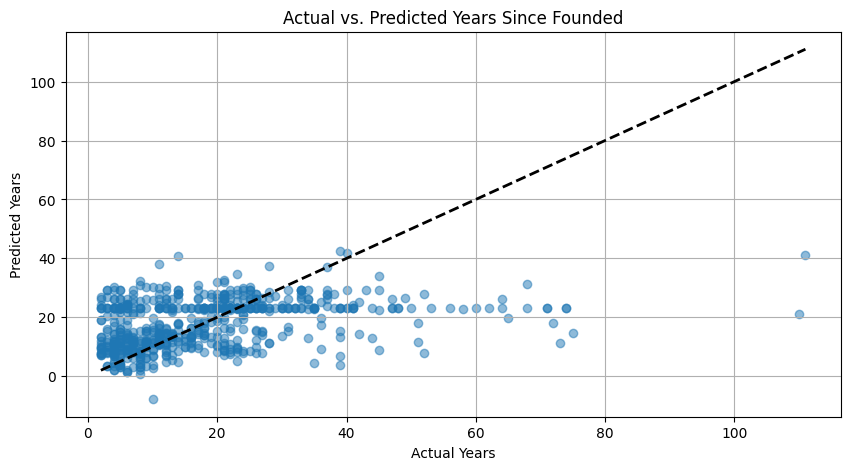

In [11]:
plt.figure(figsize=(10, 5))
plt.scatter(actual_years, predicted_years, alpha=0.5)
plt.title('Actual vs. Predicted Years Since Founded')
plt.xlabel('Actual Years')
plt.ylabel('Predicted Years')
plt.plot([actual_years.min(), actual_years.max()], [actual_years.min(), actual_years.max()], 'k--', lw=2)  # Diagonal line
plt.grid(True)
plt.show()
